# COSC 325 - LECTURE 05 - Bayes Optimal Classifier, Data Preparation and Model Evaluation

In this lecture you will learn basic steps to prepare your data for model training and how to evaluate your model after training.

Requirements:
- Python3
- JupyterLab
- Numpy
- Pandas
- Scikit-learn
- Matplotlib

**Acknowledgements**  
This notebook is inspired in part by the following sources:
- Dr. Sebastian Raschka [ML course](https://sebastianraschka.com/blog/2021/ml-course.html). In particular, we are using portions of the following notebooks
    - [Data Preprocessing](https://github.com/rasbt/stat451-machine-learning-fs20/blob/master/L05/code/05-preprocessing-and-sklearn__notes.ipynb)
    - [Model Evaluation]()
- Alexis Cook [Titanic Tutorial](https://www.kaggle.com/code/alexisbcook/titanic-tutorial)
- Muhammad Hamza Nawaz [Titanic Tutorial](https://www.kaggle.com/code/muhammadhamzanawaz/titanic-classification-using-machine-learning)

In [18]:
%load_ext watermark  
%watermark -v -a 'Hector Santos' -p pandas,numpy,matplotlib

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Author: Hector Santos

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.26.0

pandas    : 2.2.2
numpy     : 1.26.4
matplotlib: 3.9.2



In [19]:
# New Library
#!pip install kaggle

## Notebook Setup

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import zipfile
from tqdm import tqdm

# Random generator
rng1 = np.random.RandomState(seed=123)


## Bayes Optimal Classifier Demonstration

This code demonstrate Theorem #1 Bayes Optimal Classifier (BOC).

Note that when implementing these models, the current samples $X$ extracted from the  distribution $f$ can dramatically change the validation accuracy of the models. Therefore, for some seeds, other methods may perform better than BOC. However, in general, the theoritical model should outperform other models.

Things to note:
 - There is no training of the BOC, because we use the exact distribution $f$
 - Naive Bayes will perform similarly to BOC, because it is estimating the posterior probability from the data using a Gaussian prior and our synthetic data fits this prior well.

In [21]:
# Helper function to plot decision boundaries of 2D use cases using seaborn
def plot_decision_boundary(clf, X, y, title, ax):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.8)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette="coolwarm", edgecolor="k", ax=ax)
    ax.set_title(title)

Probability of error:
	Bayes Optimal Classifier: 0.0233
	Naive Bayes Classifier: 0.0267
	Logistic Regression: 0.0267
	K-Nearest Neighbors: 0.0333
R-squared scores:
	Bayes Optimal Classifier: 0.9062
	Naive Bayes Classifier: 0.8928
	Logistic Regression: 0.8928
	K-Nearest Neighbors: 0.8659


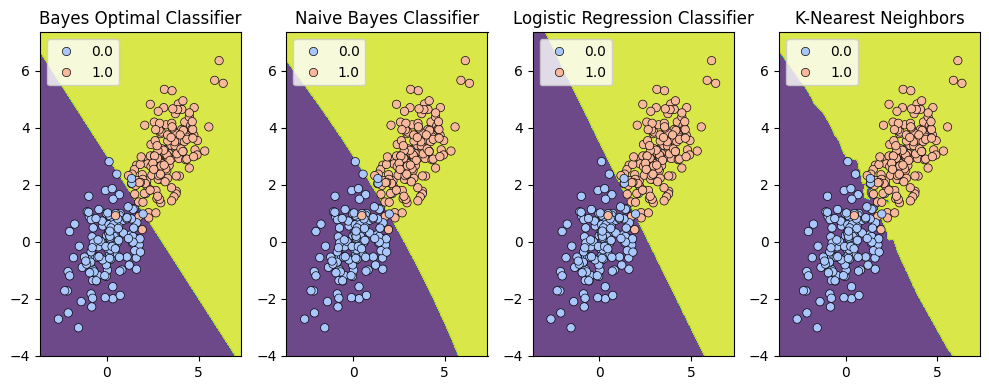

In [22]:
############################################################################################
# Step 1: Generate Synthetic Data
rng1.seed(51)  # You can change the seed to experiment with different samples
n_samples = 1000

# Class 0: Gaussian centered at (0, 0)
X_class0 = rng1.multivariate_normal(mean=[0, 0], cov=[[1, 0.5], [0.5, 1]], size=n_samples // 2)
y_class0 = np.zeros(n_samples // 2)

# Class 1: Gaussian centered at (2, 2)
X_class1 = rng1.multivariate_normal(mean=[3, 3], cov=[[1, 0.5], [0.5, 1]], size=n_samples // 2)
y_class1 = np.ones(n_samples // 2)

# Combine the data
X = np.vstack((X_class0, X_class1))
y = np.hstack((y_class0, y_class1))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rng1, shuffle=True)

############################################################################################
# Step 2: Bayes Optimal Classifier (using the true distribution)
def bayes_optimal_classifier(X):
    # Calculate posterior probabilities using the true distributions
    posterior_class0 = np.exp(-0.5 * np.sum((X - np.array([0, 0])) @ np.linalg.inv([[1, 0.5], [0.5, 1]]) * (X - np.array([0, 0])), axis=1))
    posterior_class1 = np.exp(-0.5 * np.sum((X - np.array([3, 3])) @ np.linalg.inv([[1, 0.5], [0.5, 1]]) * (X - np.array([3, 3])), axis=1))
    #note @ is another operator for matrix multiplication

    # Assume equal priors for simplicity
    posterior_class0 *= 0.5
    posterior_class1 *= 0.5

    # Predict the class with the highest posterior probability
    return np.where(posterior_class1 > posterior_class0, 1, 0)

############################################################################################
# Step 3: Train other classifiers and predict from models for comparison

# Compute Optimal Bayes predictions
y_pred_bayes = bayes_optimal_classifier(X_test)

# Naive Bayes Classifier
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)
y_pred_nb = nb_classifier.predict(X_test)

# Logistic Regression
logreg_classifier = LogisticRegression()
logreg_classifier.fit(X_train, y_train)
y_pred_logreg = logreg_classifier.predict(X_test)

# K-Nearest Neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)
y_pred_knn = knn_classifier.predict(X_test)

############################################################################################
# Step 4: Evaluate and Compare Classifiers
# compute the probability of error for each classifier
error_bayes = np.mean(y_pred_bayes != y_test)
error_nb = np.mean(y_pred_nb != y_test)
error_logreg = np.mean(y_pred_logreg != y_test)
error_knn = np.mean(y_pred_knn != y_test)
print("Probability of error:")
print(f"\tBayes Optimal Classifier: {error_bayes:.4f}")
print(f"\tNaive Bayes Classifier: {error_nb:.4f}")
print(f"\tLogistic Regression: {error_logreg:.4f}")
print(f"\tK-Nearest Neighbors: {error_knn:.4f}")  

# Also compute R-squared scores for regression perspective
r2_bayes = r2_score(y_test, y_pred_bayes)
r2_nb = r2_score(y_test, y_pred_nb)
r2_logreg = r2_score(y_test, y_pred_logreg)
r2_knn = r2_score(y_test, y_pred_knn)
print("R-squared scores:")
print(f"\tBayes Optimal Classifier: {r2_bayes:.4f}")
print(f"\tNaive Bayes Classifier: {r2_nb:.4f}")
print(f"\tLogistic Regression: {r2_logreg:.4f}")
print(f"\tK-Nearest Neighbors: {r2_knn:.4f}")

############################################################################################
# Step 5: Plot decision boundaries using Seaborn with subplots
# Create a 1x4 subplot
fig, axes = plt.subplots(1, 4, figsize=(10, 4))
plot_decision_boundary(bayes_optimal_classifier, X_test, y_test, "Bayes Optimal Classifier", axes[0])
plot_decision_boundary(nb_classifier.predict, X_test, y_test, "Naive Bayes Classifier", axes[1])
plot_decision_boundary(logreg_classifier.predict, X_test, y_test, "Logistic Regression Classifier", axes[2])
plot_decision_boundary(knn_classifier.predict, X_test, y_test, "K-Nearest Neighbors", axes[3])
plt.tight_layout()
plt.show()

 


## Kaggle

Kaggle is an excellent playground to improve your ML skills. This notebook will help you learn how to download Kaggle datasets into your computer.

- Create a Kaggle account <https://www.kaggle.com/>
- Go to your Kaggle account settings at: <https://www.kaggle.com/settings>.
- Scroll down to the API section and click on Create New API Token.
- This will download a file called `kaggle.json`, which contains your API key and username.
- Move file to ~/.kaggle/kaggle.json

### Load titanic dataset
The titanic dataset offers an excellent playground for data wrangling practice. It is impacted by missing values, scaling issues, and categorical information. We will explore how to prepare the Titanic dataset for model training.

Feel free to explore Kaggle's Titanic page [<https://www.kaggle.com/c/titanic>].

In [23]:
# Make it True and run this code block once to load dataset 
# from kaggle's website into your computer
if False:
    # load data from web
    !kaggle competitions download -c titanic

    # Unzip the dataset
    with zipfile.ZipFile('titanic.zip', 'r') as zip_ref:
        zip_ref.extractall('titanic_data')

# Ready to read CSV files
# Prepare training and test sets
train_df_ori = pd.read_csv('titanic_data/train.csv')
test_df_ori = pd.read_csv('titanic_data/test.csv')

# Copy dataframes
train_df = train_df_ori.copy()
test_df = test_df_ori.copy()

## Basic Data Preprocessing
Before performing any data manipulation, understand your use case and data.

Which features are redundant?

<https://www.kaggle.com/c/titanic>

Some general steps:
- Remove irrelevant features
- Remove co-linear features
- Manage missing data
- Transform your data
    - Scaling
    - Polynomial transformation

### Remove irrelevant features

**Data Dictionary**
| Variable | Definition | Key |
|----------|------------|-----|
| PassengerID | Unique number identifier per passenger | Integer |
| Survived | Survival | 0 = No, 1 = Yes |
| Pclass | Ticket class	|1 = 1st, 2 = 2nd, 3 = 3rd |
| Name | Passenger name | String |
| Sex | Sex | female or male |	
| Age | Age | In years or fractional if less than 1. If the age is estimated, is it in the form of xx.5 |	
| sibsp | # of siblings / spouses aboard the Titanic | Integer |	
| parch	| # of parents / children aboard the Titanic | Integer |	
| ticket | Ticket number |	String |
| fare | Passenger fare | $ |
| cabin | Cabin number	| String |
| embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |

In [24]:
# Print head of dataframe
display(train_df.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [25]:
# No information about certain features?
# Print unique values
print(f'Sex: {train_df['Sex'].unique()}')
print(f'Parch: {train_df['Parch'].unique()}')
print(f'Embarked: {train_df['Embarked'].unique()}')
print(f'Class: {train_df['Pclass'].unique()}')

Sex: ['male' 'female']
Parch: [0 1 2 5 3 4 6]
Embarked: ['S' 'C' 'Q' nan]
Class: [3 1 2]


**Notes**
- Obviously not relevant
    - PassengerID: It is a unique identifier per sample
- Inclined to drop
    - Name

In [26]:
# Drop irrelevant features
irrelevant_feats = ['PassengerId', 'Name']
train_df.drop(irrelevant_feats, axis=1, inplace=True)
test_df.drop(irrelevant_feats, axis=1, inplace=True)

### Missing values


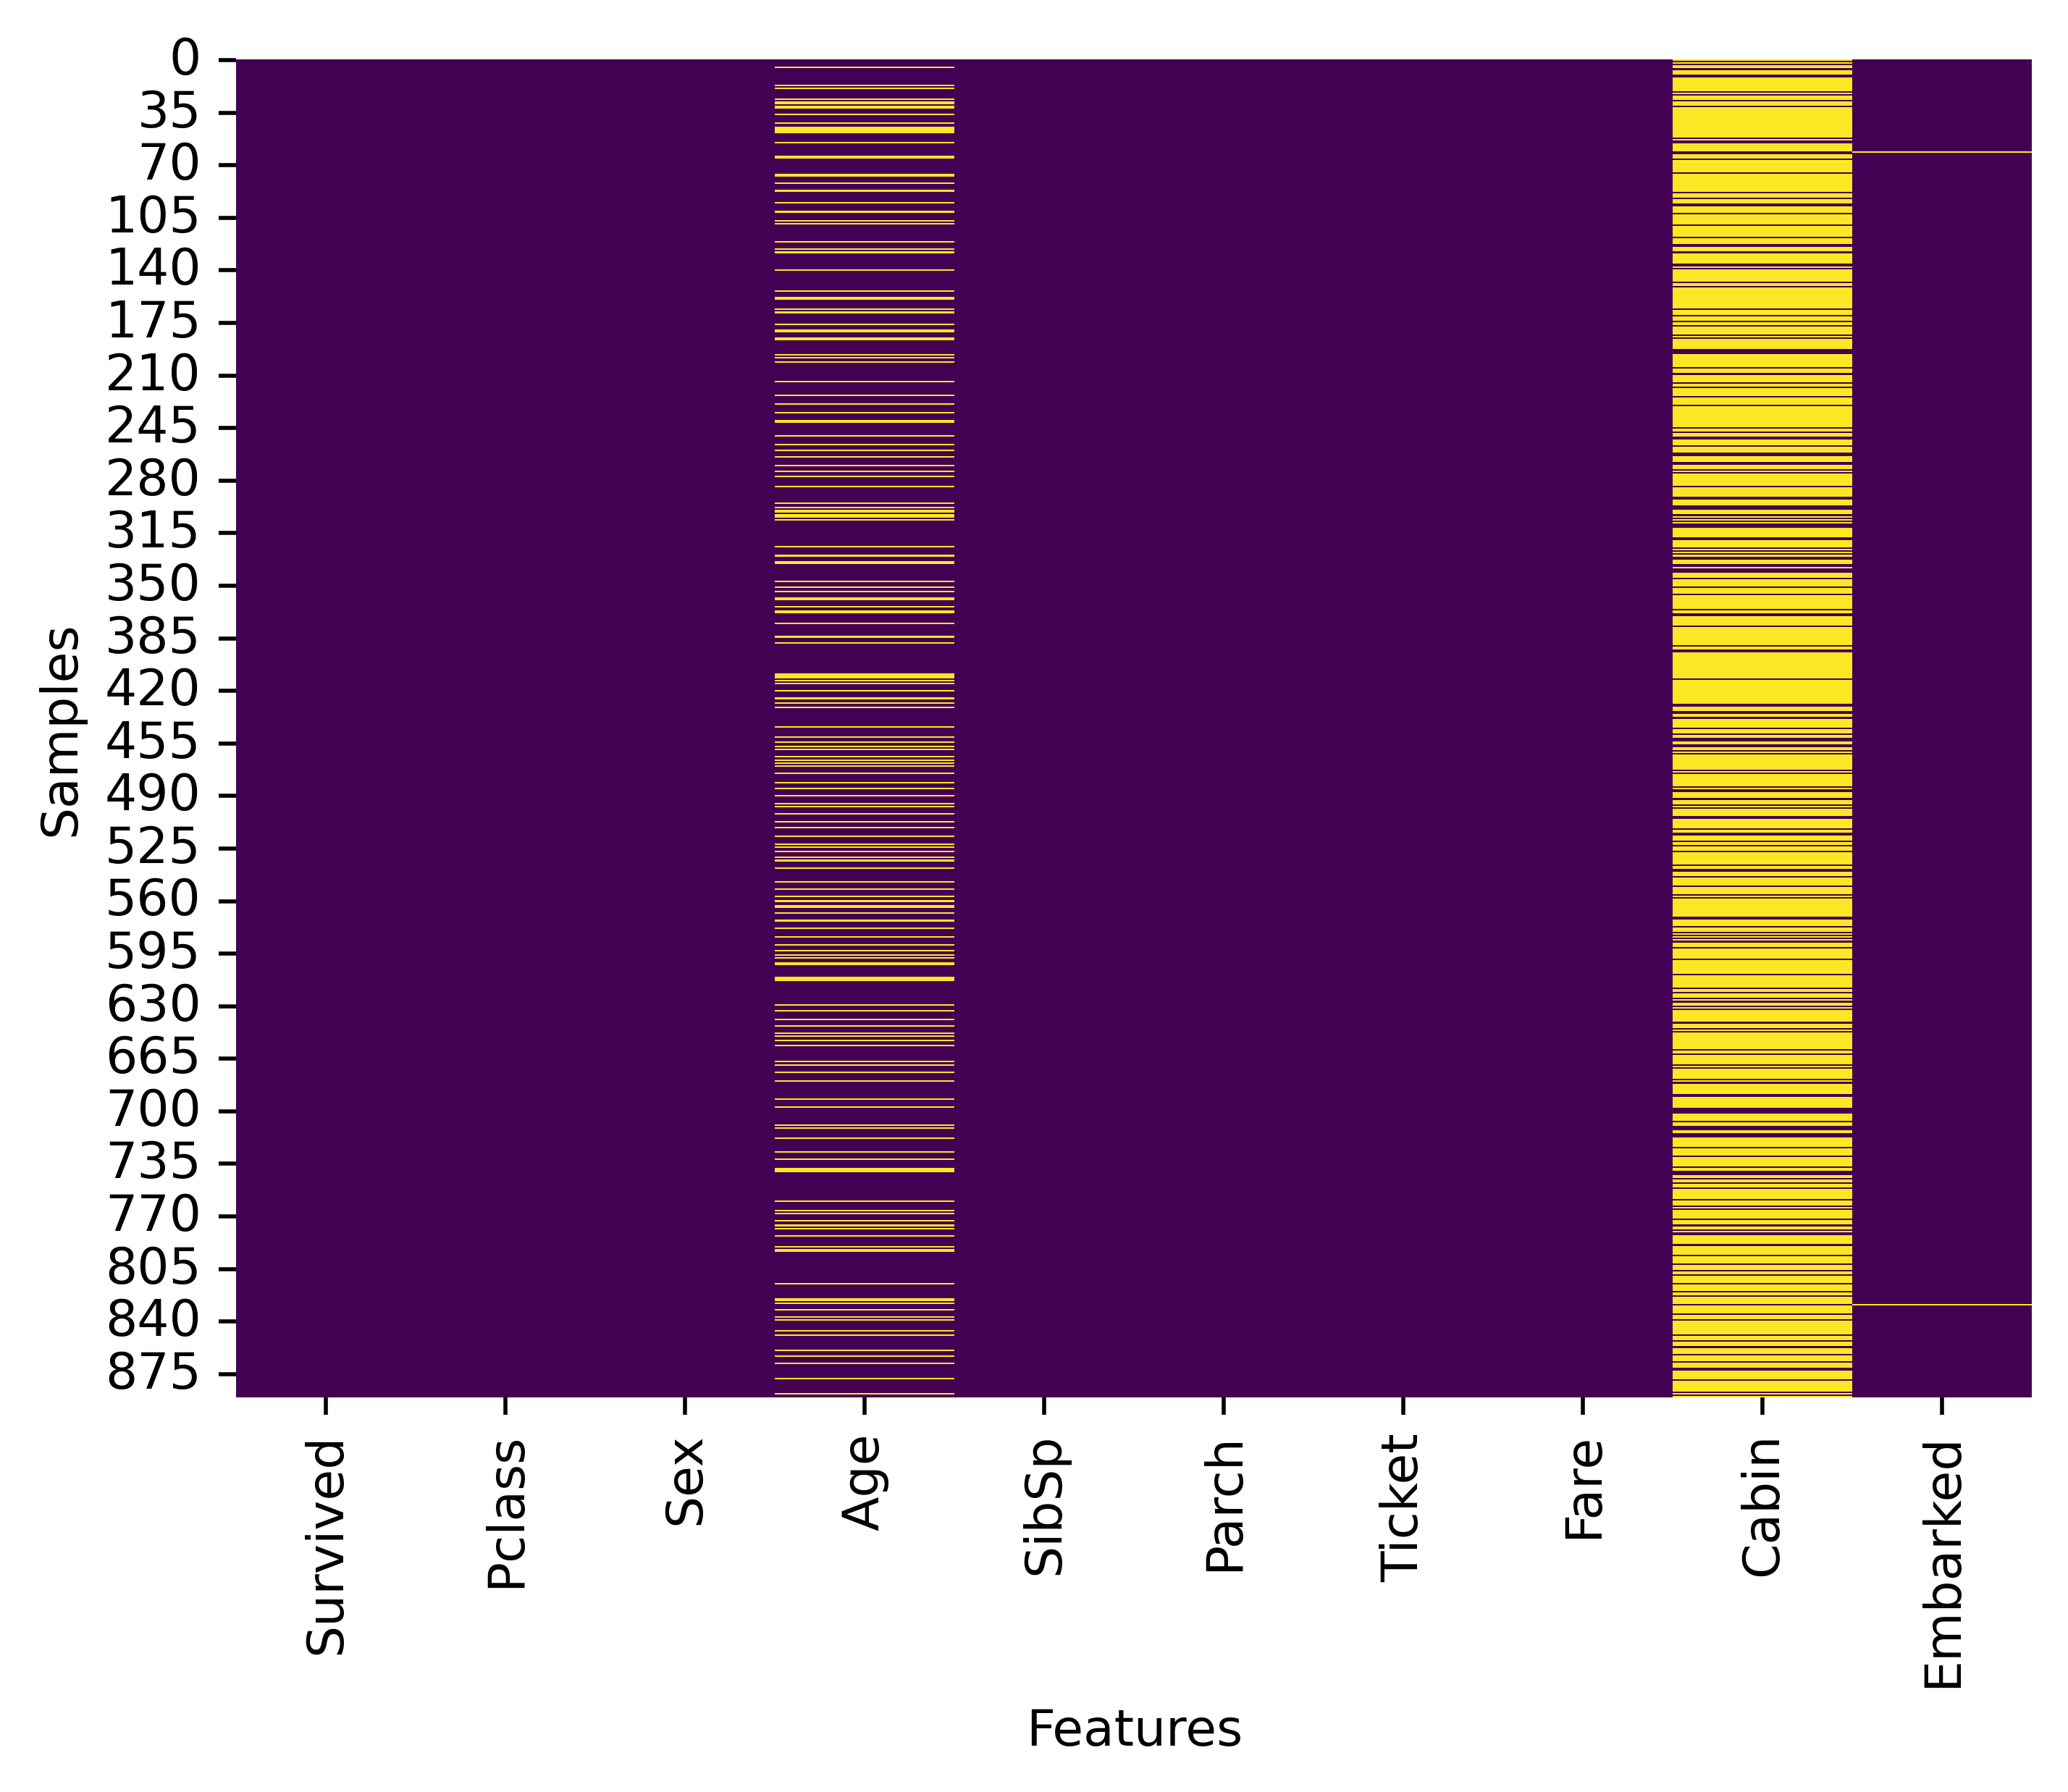

In [27]:
plt.figure(dpi=500) # increase to ensure you can see each row
sns.heatmap(train_df.isnull() , cbar=False , cmap='viridis')
plt.ylabel('Samples')
plt.xlabel('Features')
plt.show()

**Notes**
- Cabin values are virtually absent and information may be correlated with Pclass.
- Ticket may contain some important information, but it may be correlated to Pclass and getting in good shape for training can be a too elaborate process. Let's continue without it for now.
- Age may be important, but too many missing values. Let's try to fill those missing values.
- Note some sparse missing values in Embarked. We may want to remove those samples.


In [28]:
# Remove features with too many missing values
missing_too_many = ['Cabin', 'Ticket']
train_df.drop(missing_too_many, axis=1, inplace=True)
test_df.drop(missing_too_many, axis=1, inplace=True)

### Missing Values with Replacement

Sometimes, you want to replace values with a statistic about the data. For example, we may want to replace a missing fare value with the average fare or if the class is known, we can replace a missing value with the average fair value for the corresponding class. 

We need to fill the missing values for the age feature. We can get fancy here by using heuristics to compute a replacement age. For example, can we use the Parch and SibSp features to predict if the passenger is a kid or an adult and assign an average age for that group, etc. For now, we will use the total sample average or median age.

You can use   
    `from sklearn.impute import SimpleImputer`  
Then, in your code you can write something like:  
    `imputer = SimpleImputer(missing_values=np.nan, strategy='mean')`  
    `X = imputer.fit_transform(df.values)`  
This will replace a column's missing values with the average column value.

In [29]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median') 
age_fill = imputer.fit_transform(train_df['Age'].values.reshape(-1,1))
train_df['Age'] = age_fill
age_fill = imputer.transform(test_df['Age'].values.reshape(-1,1))
test_df['Age'] = age_fill

In [30]:
# Remove specific samples with missing values
for column in train_df.columns[1:]: # Starts at 1 to skip target column only in training set
#specific_samples = ['Embarked']
    train_df.dropna(subset=column, axis=0, inplace=True)
    test_df.dropna(subset=column, axis=0, inplace=True)


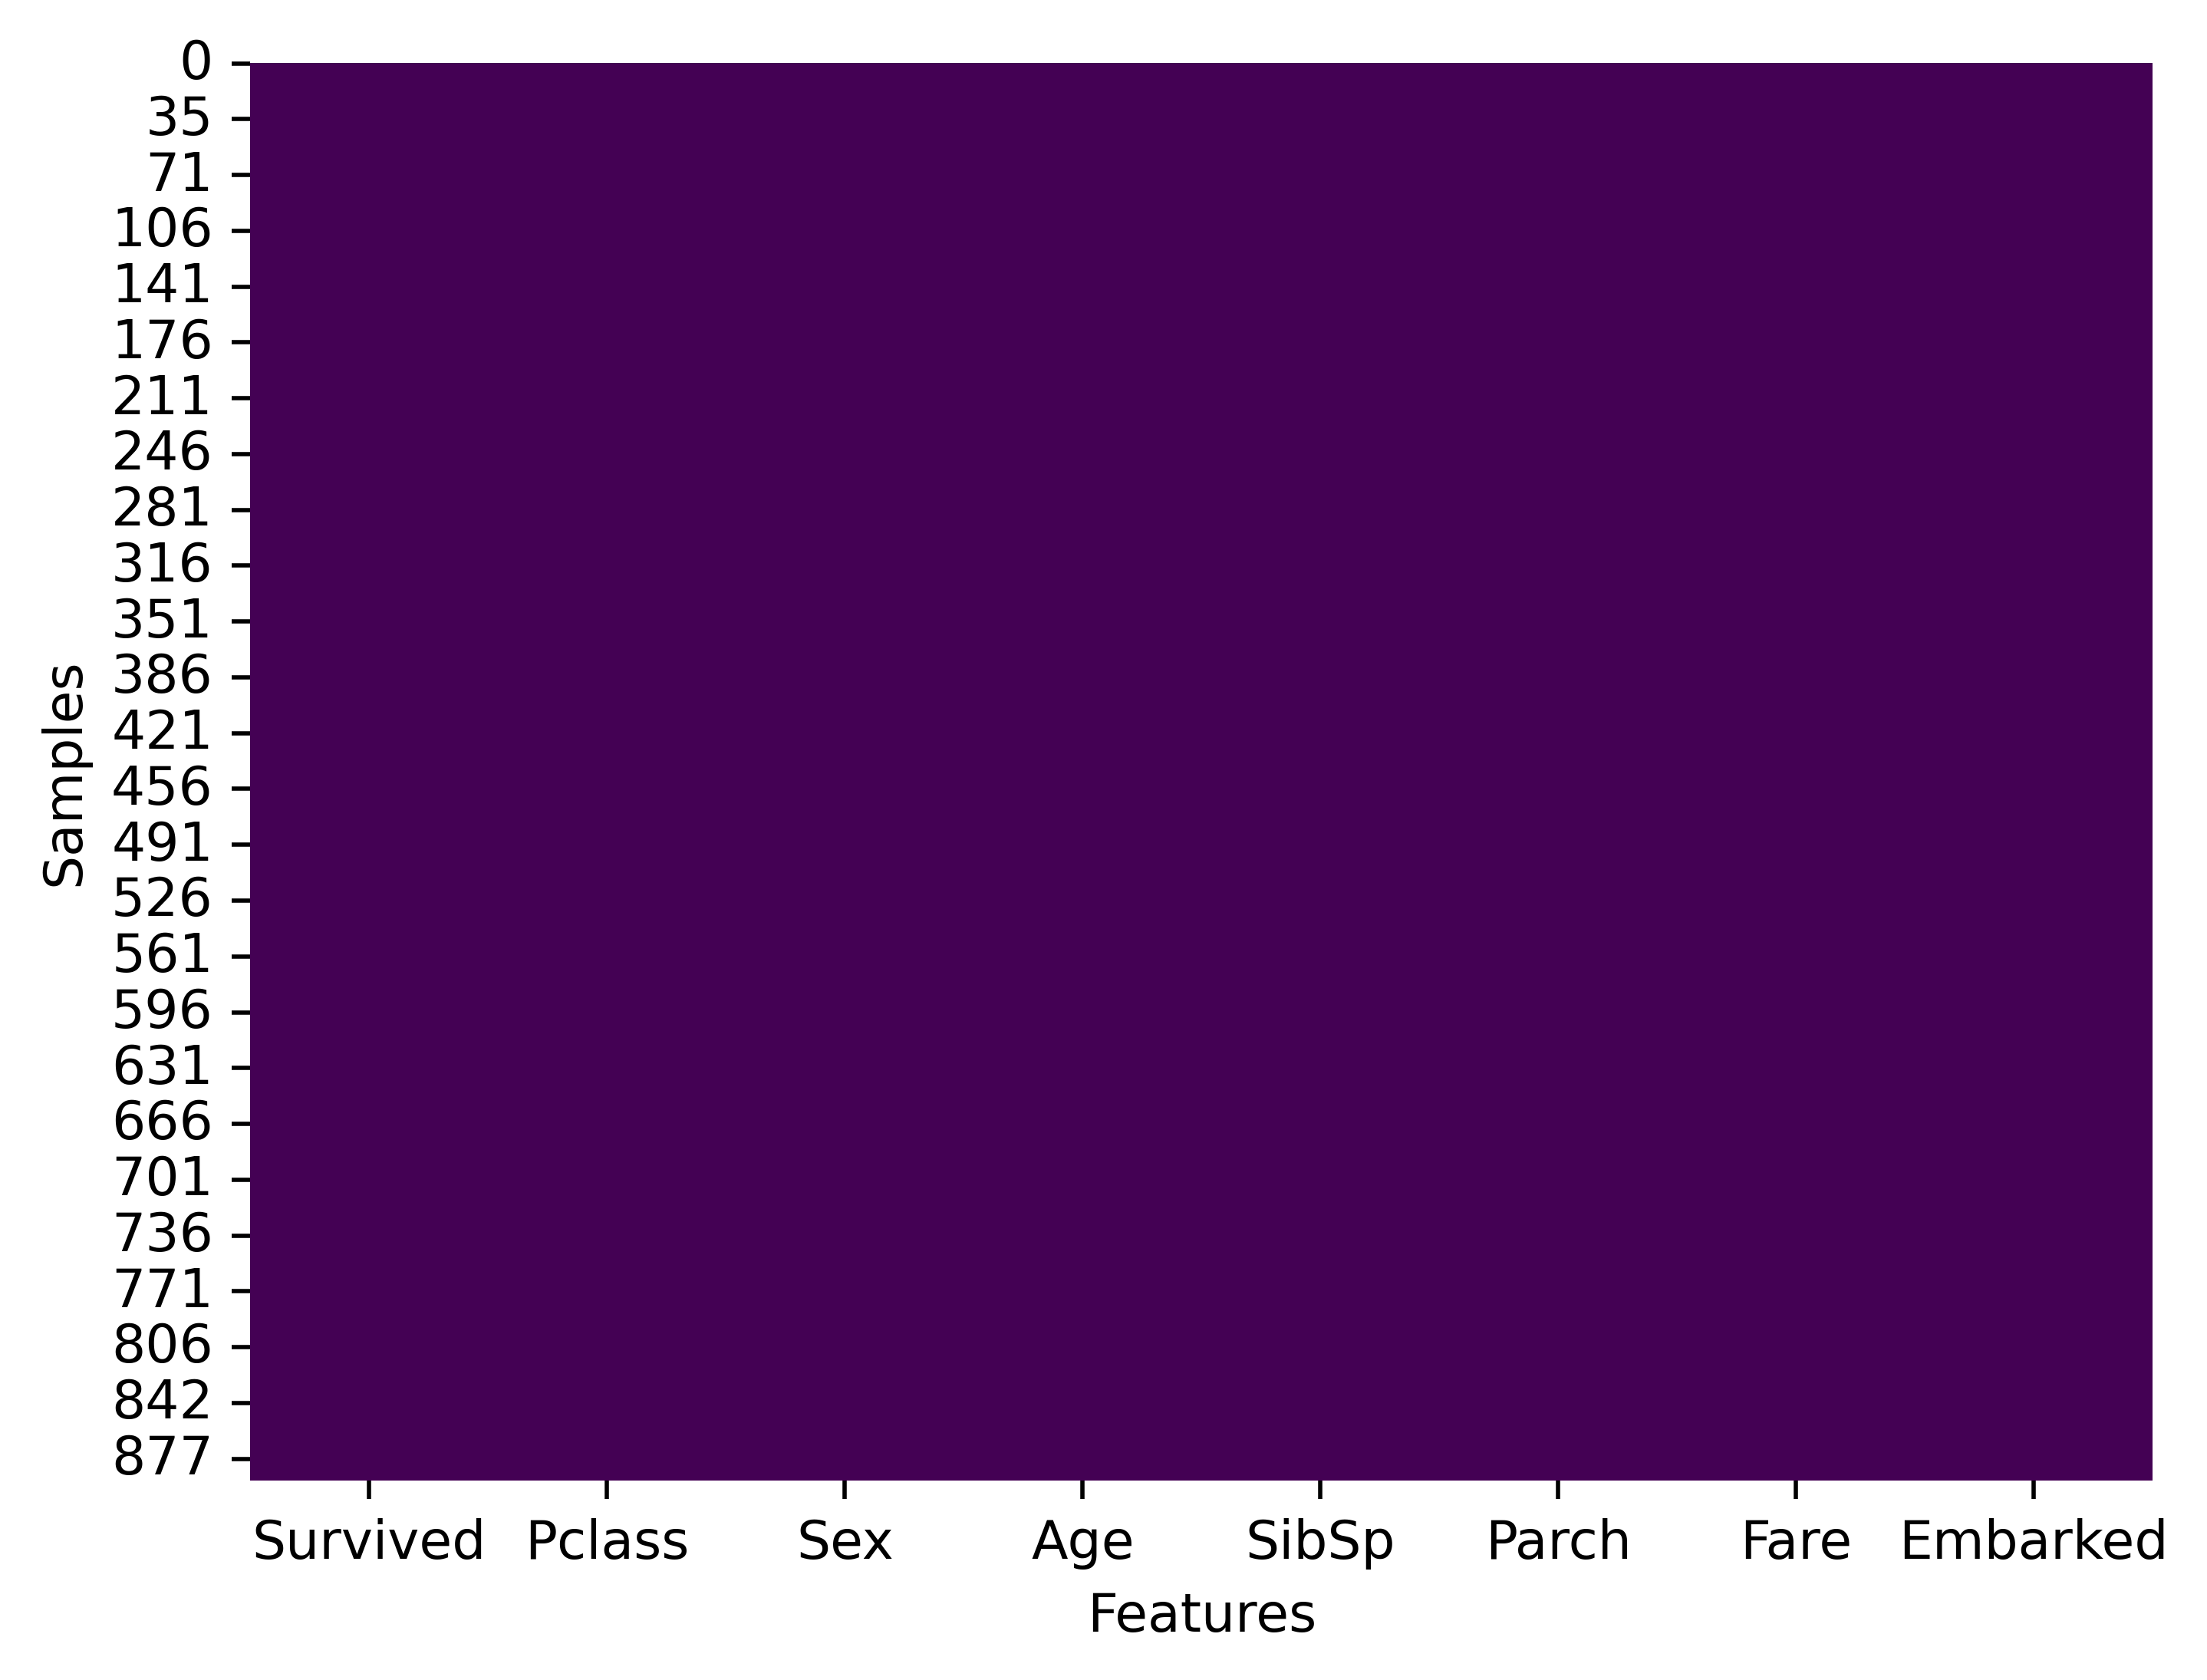

In [31]:
plt.figure(dpi=500) # increase to ensure you can see each row
sns.heatmap(train_df.isnull() , cbar=False , cmap='viridis')
plt.ylabel('Samples')
plt.xlabel('Features')
plt.show()

### One-hot-encoding of categorical features

Convert categorical values to integers. Note Ticket column is a unique identifier that we should not encode. More on this feature later.

We have three tools:
- Dataframe `apply`: applies a transformation one at a time
- Dataframe `map`: applies multiple transformation given a dictionary of original values -> new values
- Dataframe `get_dummies`: automatically identify categorical values and one-hot-encodes these values. Note that it will create one colinear feature per categorical feature.
- sklearn `OneHotEncoder`: automatically identify categorical values and one-hot-encodes these values. Note that it will create one colinear feature per categorical feature. It can be easily integarted into a pipeline. More on this later.

In [32]:
def dataframe_onehotencoder(encoder, df, columns_names, fit_transform=True):
    '''
    This is a helper function to apply sklearn onehotencoder function
    on multiple columns of a data frame.

    Args:
        encoder: initialized OneHotEncoder
        df: Pandas dataframe with data
        columns_names: names of the columns in dataframe to encode
        fit_transform: True when the encoder is seeing the categorical data for the first time; False otherwise.
    
    Returns:
        dataframe: with one-hot-encoded columns
    '''
    
    # One-hot-encode the columns in column names
    if(fit_transform):
        data = encoder.fit_transform(df[columns_names])
    else:
        data = encoder.transform(df[columns_names])

    # Convert data to a dataframe
    df2 = pd.DataFrame(data, columns=encoder.get_feature_names_out(columns_names), index=df.index)
    
    # Recreate original dataframe
    df3 = pd.concat([df.drop(columns_names, axis=1), df2], axis=1)
    
    # Return
    return df3 


In [33]:
# Example of using apply on Sex
Sex = train_df['Sex'].apply(lambda x: 0 if x=='female' else 1)
display(Sex.head())

#Example of using map on Embarked
mapping_dict = {'S':0, 'C':1, 'Q':2}
Embarked = train_df['Embarked'].map(mapping_dict)
# Note the previous map call will take three separate apply calls
display(Embarked.head())

# Example using get_dummies
df_dummy = pd.get_dummies(train_df, drop_first=True)
display(df_dummy.head()) 

# Example using SKLearn OneHotEncoder
columns_to_encode = ['Sex', 'Embarked']
encoder = OneHotEncoder(drop='first', sparse_output=False) # drops first feature to avoid colinear features
df_OHE = dataframe_onehotencoder(encoder=encoder, df=train_df, columns_names=columns_to_encode, fit_transform=True)
display(df_OHE.head())

# Let's use OneHotEncoding for Later Pipeline example
train_df = dataframe_onehotencoder(encoder=encoder, df=train_df, 
                                   columns_names=columns_to_encode, fit_transform=True)
test_df = dataframe_onehotencoder(encoder=encoder, df=test_df, 
                                  columns_names=columns_to_encode, fit_transform=False)


0    1
1    0
2    0
3    0
4    1
Name: Sex, dtype: int64

0    0
1    1
2    0
3    0
4    0
Name: Embarked, dtype: int64

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,True,False,True
1,1,1,38.0,1,0,71.2833,False,False,False
2,1,3,26.0,0,0,7.9250,False,False,True
3,1,1,35.0,1,0,53.1000,False,False,True
4,0,3,35.0,0,0,8.0500,True,False,True


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,1.0,0.0,1.0
1,1,1,38.0,1,0,71.2833,0.0,0.0,0.0
2,1,3,26.0,0,0,7.9250,0.0,0.0,1.0
3,1,1,35.0,1,0,53.1000,0.0,0.0,1.0
4,0,3,35.0,0,0,8.0500,1.0,0.0,1.0


### Remove colinear features

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,1.0,0.0,1.0
1,1,1,38.0,1,0,71.2833,0.0,0.0,0.0
2,1,3,26.0,0,0,7.9250,0.0,0.0,1.0
3,1,1,35.0,1,0,53.1000,0.0,0.0,1.0
4,0,3,35.0,0,0,8.0500,1.0,0.0,1.0


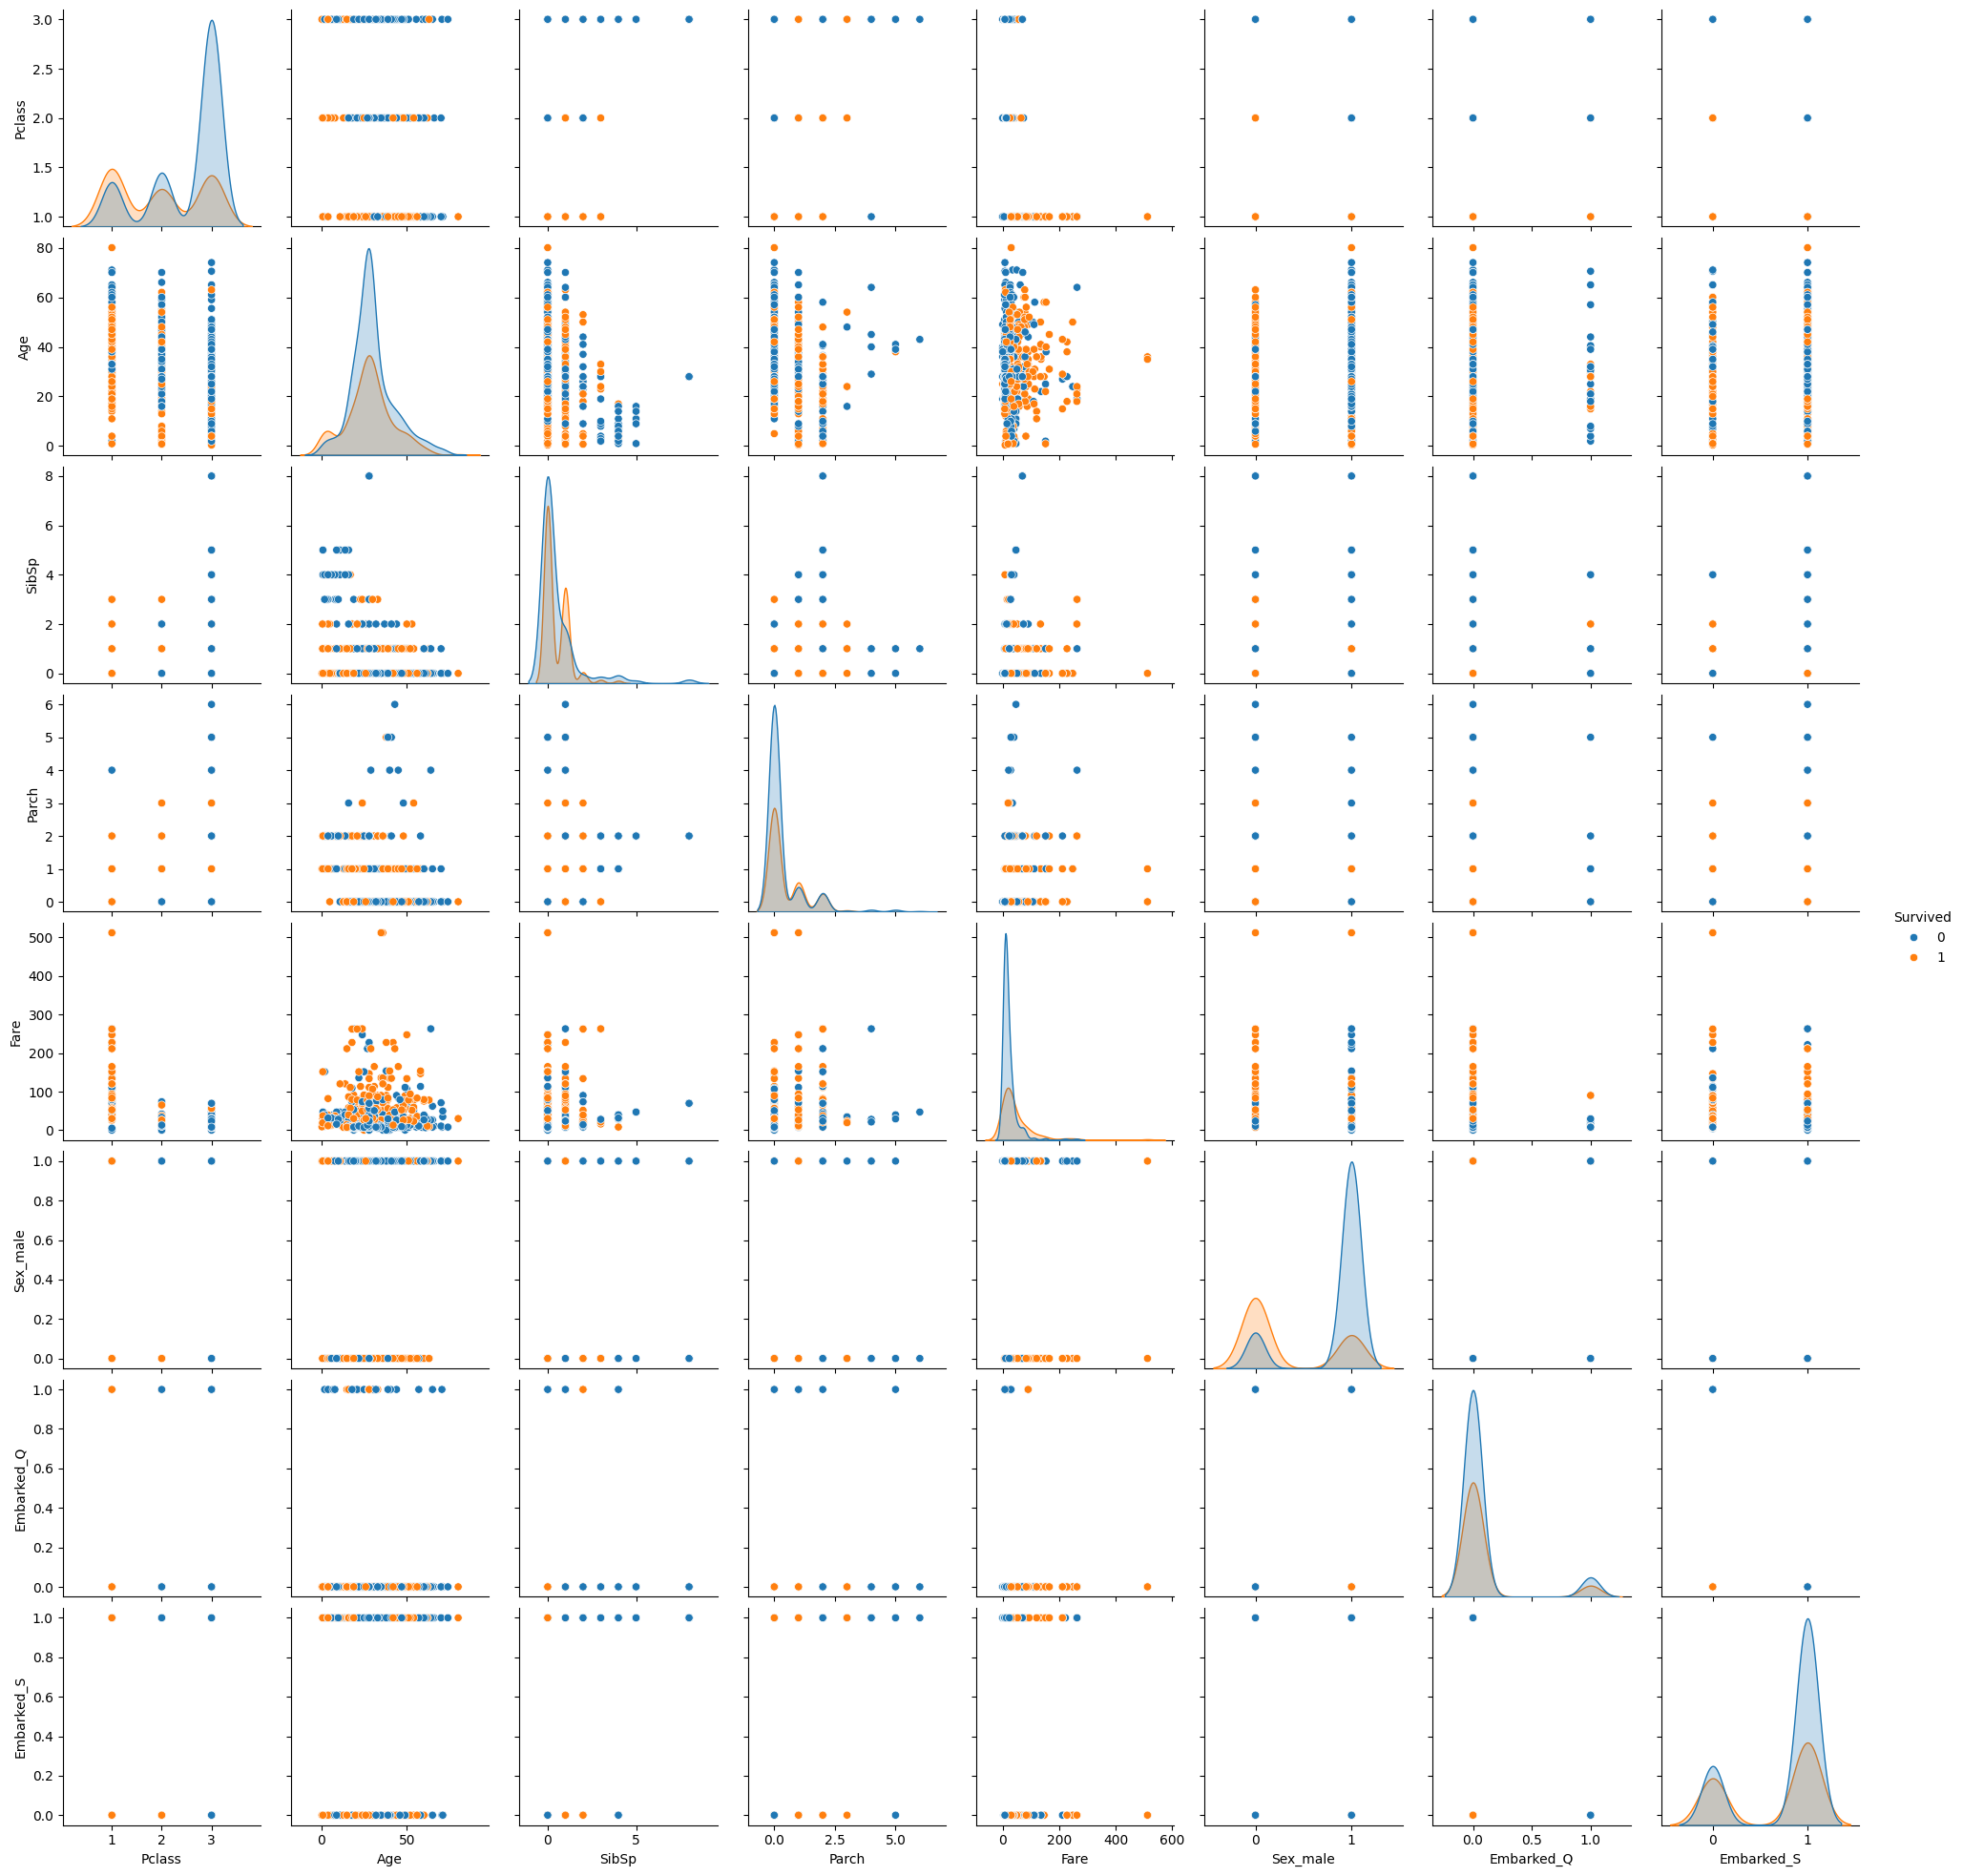

In [34]:
# Display current dataframe
display(train_df.head())

# Display scatter plots
sns.pairplot(train_df, hue='Survived')

In [35]:
def dataframe_normalization(transformer, df, fit_transform=True):
    '''
    This is a helper function to normalize the dataset features using the ColumnTransformer class.

    Args:
        transformer: initialized ColumnTransformer
        df: Pandas dataframe with the data
        fit_transform: True when the transformer is seeing the data for the first time; False otherwise.
    
    Returns:
        dataframe: with specific normalized columns
    '''
    
    # Copy data
    df2 = df.copy()

    if(fit_transform):
        data = transformer.fit_transform(df2)
    else:
        data = transformer.transform(df2)

    # Add normalized data to dataframe
    for index, column in enumerate(transformer.get_feature_names_out()):
        df2[column] = data[:,index]
        
    # Return
    return df2 

### Normalization

**Min-Max Scaling:** Values mapped to the range [0,1].
    
$x^{[i]}_{norm}=\frac{x^{[i]}-x_{min}}{x_{max}-x_{min}}$



**Standardization:** Values scaled so the mean is zero and the standard deviation is one.

$x^{[i]}_{norm}=\frac{x^{[i]}-\mu_{x}}{s_{x}}$

$\mu_x$ is the sample mean and $s_x$ is the sample deviation.

**Note**  
Observe the seaborn pairplot and decide what normalization is better for the data.

I will apply the following normalization
- Age: Standard
- Pclass: Min-Max
- SibSp: Standard (In the fence due to binomial pattern for survival group)
- Parch: Min-Max
- Fare: Standard
Other features are binary. They don't need normalization.


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,1.0,-0.563674,0.431350,0.000000,-0.500240,1.0,0.0,1.0
1,1,0.0,0.669217,0.431350,0.000000,0.788947,0.0,0.0,0.0
2,1,1.0,-0.255451,-0.475199,0.000000,-0.486650,0.0,0.0,1.0
3,1,0.0,0.438050,0.431350,0.000000,0.422861,0.0,0.0,1.0
4,0,1.0,0.438050,-0.475199,0.000000,-0.484133,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
886,0,0.5,-0.178396,-0.475199,0.000000,-0.384475,1.0,0.0,1.0
887,1,0.0,-0.794841,-0.475199,0.000000,-0.042213,0.0,0.0,1.0
888,0,1.0,-0.101340,0.431350,0.333333,-0.174084,0.0,0.0,1.0
889,1,0.0,-0.255451,-0.475199,0.000000,-0.042213,1.0,0.0,0.0


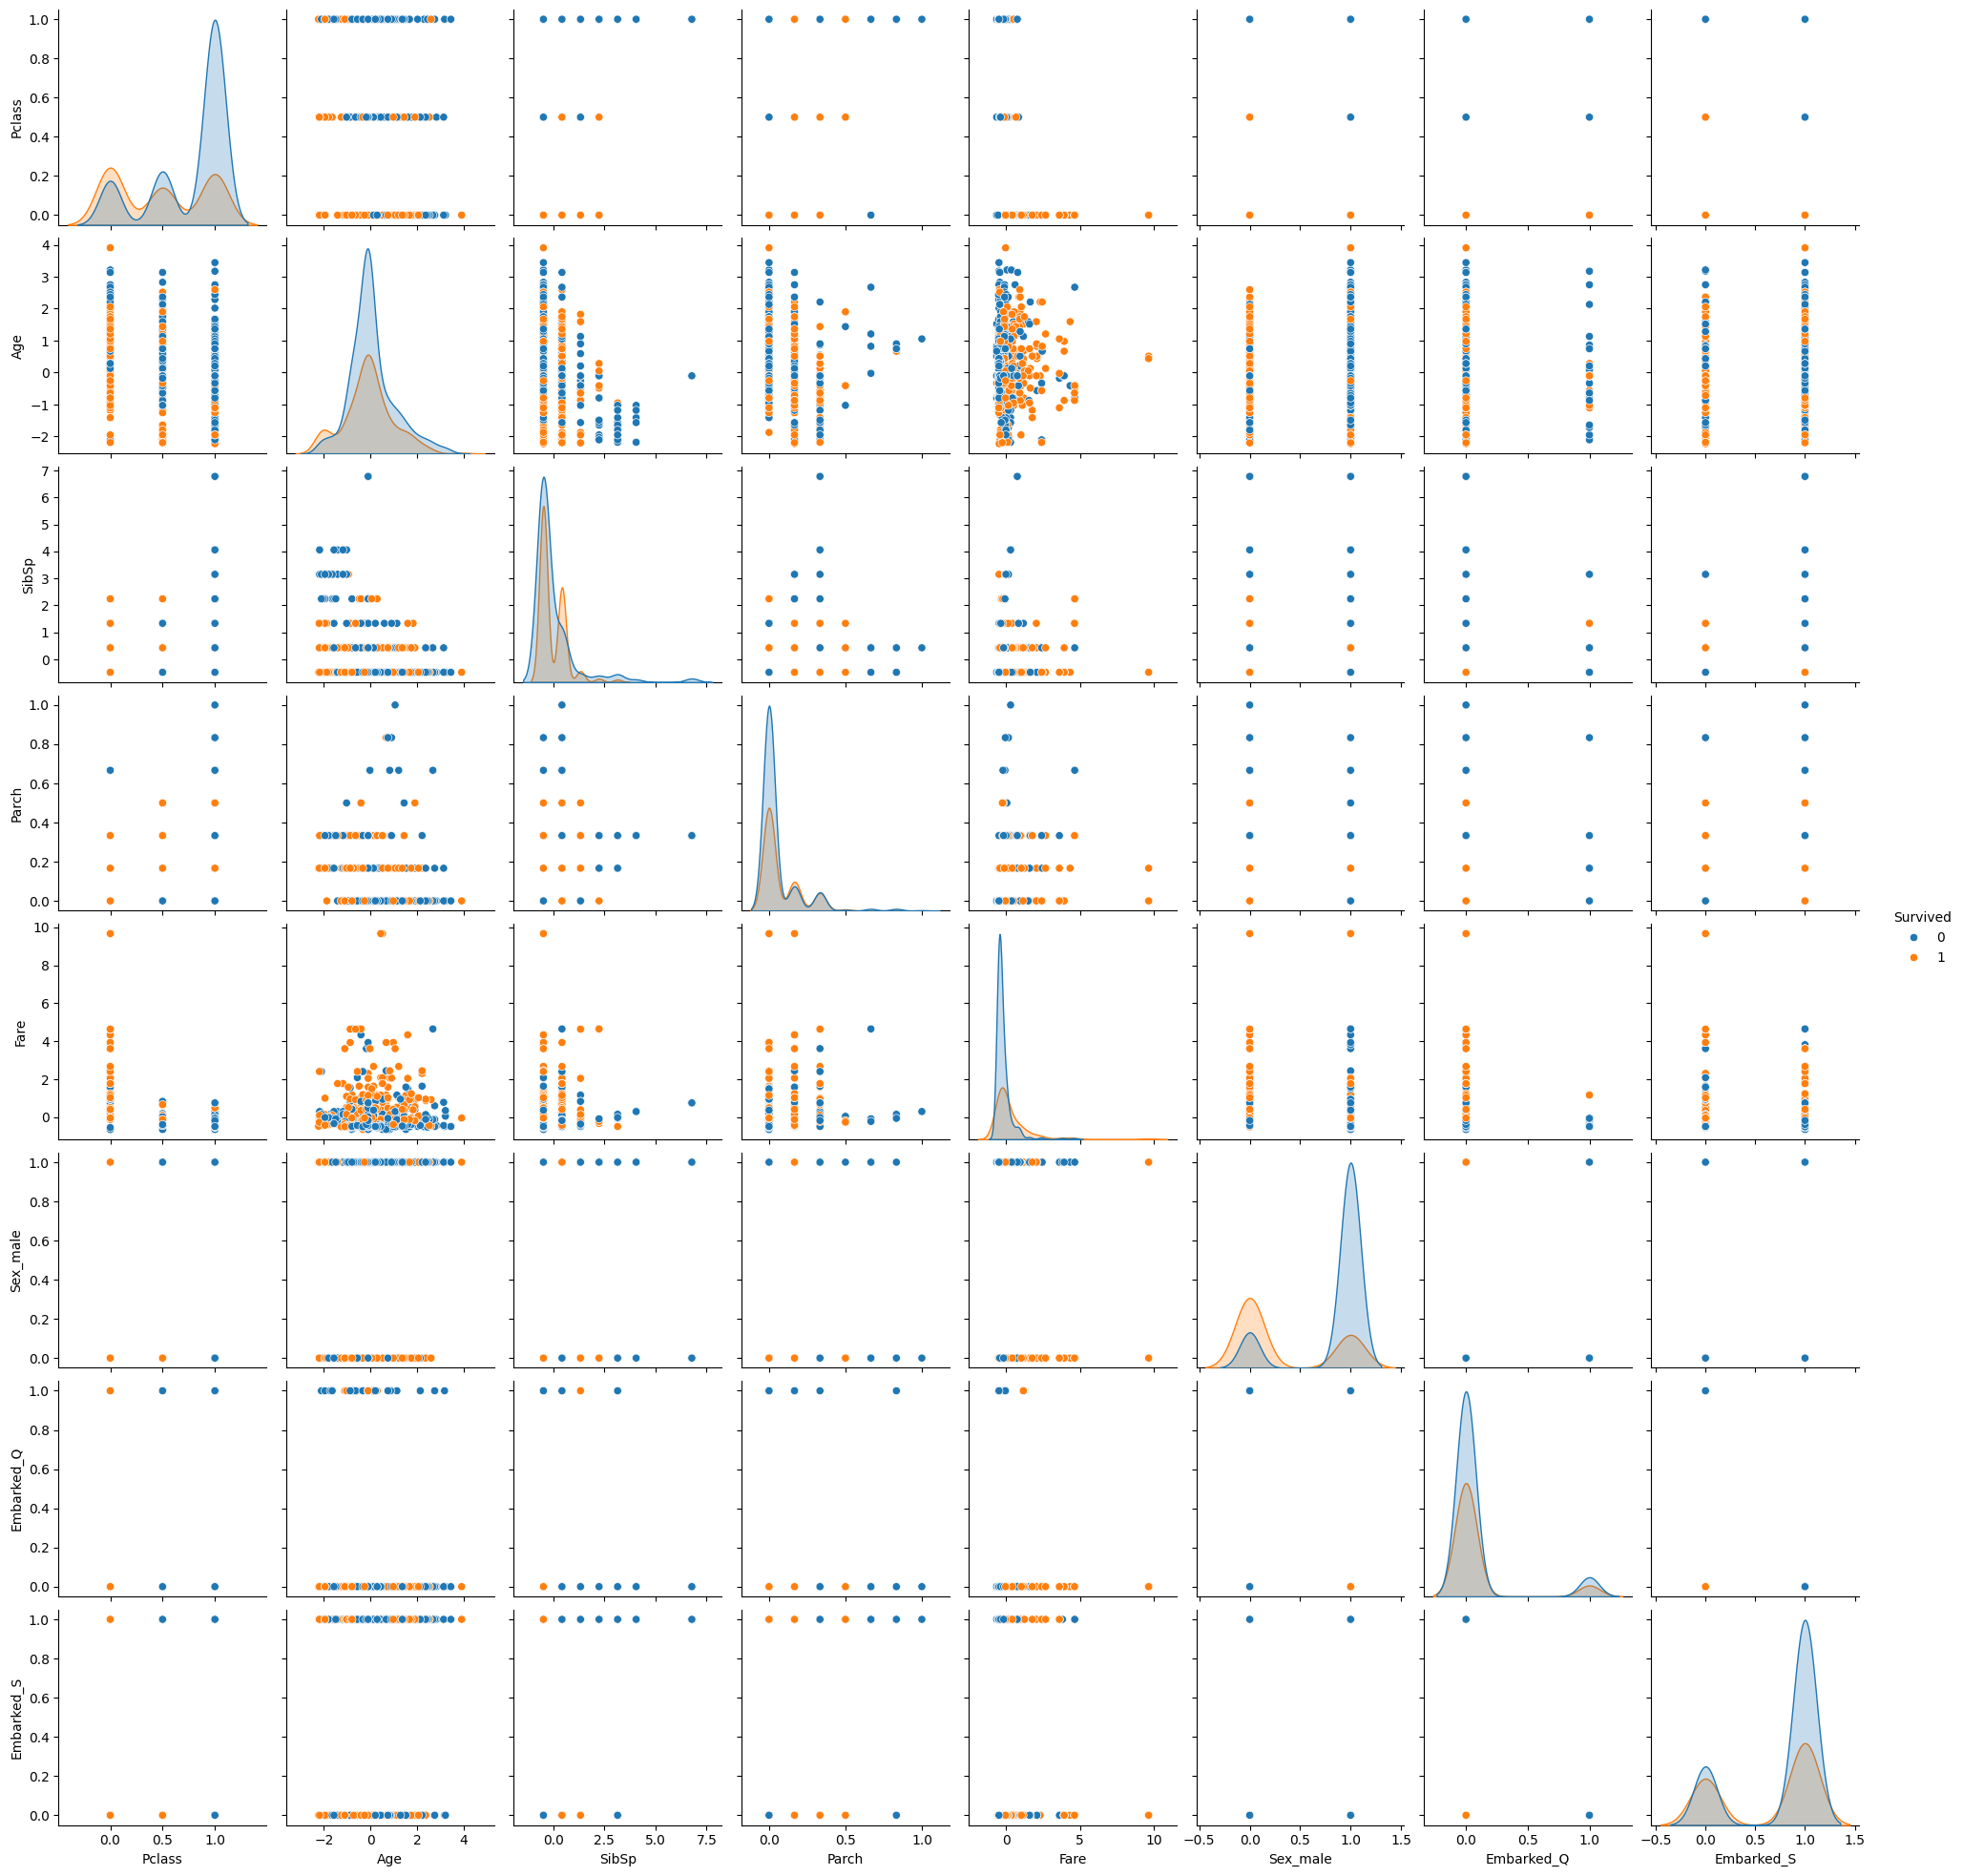

In [ ]:
# Using ColumnTransformer to apply specific normalization to each column in our data
norm_scaler = ColumnTransformer(
    transformers=[
        ('minmax', MinMaxScaler(), ['Pclass', 'Parch']),  
        ('standard', StandardScaler(), ['Age', 'SibSp', 'Fare'])
    ], verbose_feature_names_out=False
)

# Normalize data (Treat all features the same)
train_df2 = dataframe_normalization(transformer=norm_scaler, df=train_df, fit_transform=True)
test_df2 = dataframe_normalization(transformer=norm_scaler, df=test_df, fit_transform=False)

# Display table
display(train_df2)

# Display seaborn pairplot
sns.pairplot(train_df2, hue='Survived')

## Prepare for training

In [37]:
# Random engine => Replicable results? Yes.
rng1 = np.random.RandomState(seed=45)

# Generate X and y
y = train_df['Survived'].values
X = train_df.iloc[:,1:].values

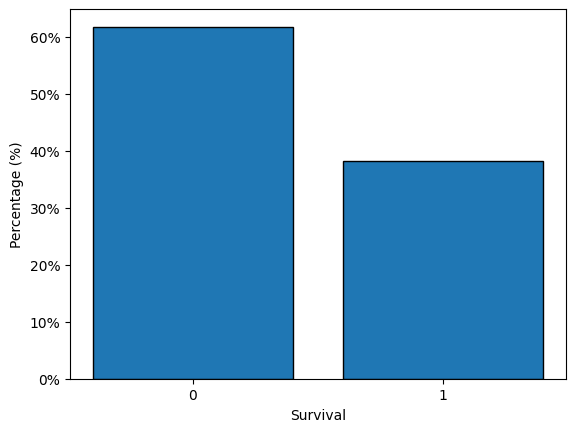

In [38]:
# Plot frequency of target classes
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(y, bins=2, edgecolor='black', rwidth=0.8, weights=np.ones(len(y)) / len(y))
ax.yaxis.set_major_formatter(PercentFormatter(1))
bin_centers = 0.5 * (bins[:-1] + bins[1:]) 
ax.set_xticks(bin_centers, [0, 1])
ax.set_xlabel('Survival')
ax.set_ylabel('Percentage (%)')
plt.show()

### Split dataset between Training and Validation sets

Based on the histogram of target classes we have more samples of deceased passengers. Therefore, we should split the dataset with stratification to ensure the proportions of the classes are equal on both sets.

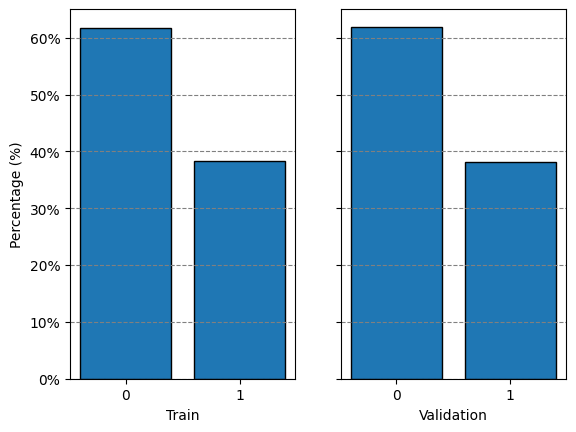

In [39]:
# Split dataset between training and validation set
# Note test_df does not have labels. This is a sequestered 
# set that you submit to Kaggle to know your results.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=rng1, stratify=y)

fig, ax = plt.subplots(1, 2, sharey=True)
counts, bins, patches = ax[0].hist(y_train, bins=2, edgecolor='black', rwidth=0.8, weights=np.ones(len(y_train)) / len(y_train))
ax[0].yaxis.set_major_formatter(PercentFormatter(1))
bin_centers = 0.5 * (bins[:-1] + bins[1:]) 
ax[0].set_xticks(bin_centers, [0, 1])
ax[0].set_xlabel('Train')
ax[0].set_ylabel('Percentage (%)')
ax[0].grid(axis='y', linestyle='--', color='gray')
counts, bins, patches = ax[1].hist(y_val, bins=2, edgecolor='black', rwidth=0.8, weights=np.ones(len(y_val)) / len(y_val))
ax[1].yaxis.set_major_formatter(PercentFormatter(1))
bin_centers = 0.5 * (bins[:-1] + bins[1:]) 
ax[1].set_xticks(bin_centers, [0, 1])
ax[1].set_xlabel('Validation')
ax[1].grid(axis='y', linestyle='--', color='gray')
plt.show()

### Pipelines
 SkLearn Pipelines allow us to keep track of all data transformations and manipulations. The manipulations include managing missing values, one-hot-encoding, scaling. The transformers learn the transformation from the training data while for the validation and testing set we only apply the transformation. Pipelines allows consistent application of these fit and transformations at the corresponding stage (Training vs Validation/Testing). 
 
 In this notebook, we only provide an example where normalization and model training are part of the pipeline. The pipeline can be constructed to handle all the manipulations in this notebook.

 **Bonus: Create an end-to-end pipeline that handles all transformations and model training in this notebook and create a 5 minute video explaining and demonstrating your approach for 5 grade points.**


In [40]:
# Using ColumnTransformer to apply specific normalization to each column in our data
norm_scaler = ColumnTransformer(
    transformers=[
        ('passthrough', 'passthrough', [5,6,7]),    # Sex, Embark-Q, Embark-S
        ('minmax', MinMaxScaler(), [0,3]),          # Pclass, Parch
        ('standard', StandardScaler(), [1,2,4])       # Age, SibSp, Fare
    ]
)

# Create pipeline: normalization and model training/testing
pipe = make_pipeline(norm_scaler, KNeighborsClassifier(n_neighbors=10))

# Train on training set
pipe.fit(X_train, y_train)

# Predict on training set
y_hat = pipe.predict(X_train)
print(f"Model training accuracy is {accuracy_score(y_train, y_hat)*100:0.2f}%")
# Predict on validation set
y_hat = pipe.predict(X_val)
print(f"Model validation accuracy is {accuracy_score(y_val, y_hat)*100:0.2f}%")

Model training accuracy is 81.59%
Model validation accuracy is 81.34%


#### Simple Model Selection
We can use SkLearn pipelines to help us search for the best model.

In [41]:
# Let's use a RandomForest
# Create pipeline: normalization and model training/testing
rf_pipe = Pipeline(steps=[
    ('norm', norm_scaler), 
    ('MLClassifier', RandomForestClassifier())
])

# Define the parameter grid to search over
param_distributions = {
    'MLClassifier__n_estimators': np.arange(100, 500, 50),   # Number of trees in the forest
    'MLClassifier__max_depth': [None, 3, 5, 10],             # Maximum depth of each tree
    'MLClassifier__min_samples_split': [2, 3, 5, 10],        # Minimum samples required to split a node
    'MLClassifier__min_samples_leaf': [1, 3, 5],             # Minimum samples required at a leaf node
    'MLClassifier__max_features': ['sqrt', None],            # Number of features to consider during split
    'MLClassifier__bootstrap': [True, False],                # Whether to bootstrap samples (i.e., bagging)
}

# Initialize RandomizedSearchCV
hyperparam_search = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=param_distributions,
    n_iter=250,                                 # Number of parameter settings sampled
    cv=3,                                       # 2-fold cross-validation
    verbose=0,                                  # Output progress
    random_state=rng1,
    n_jobs=-1,                                  # Use all available cores
    return_train_score=True                     # Include training score in the results
)

# Fit the random search model
hyperparam_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found:")
print(hyperparam_search.best_params_)

# Print average training and validation scores
print(f"Training Accuracy: {hyperparam_search.cv_results_['mean_train_score'][hyperparam_search.best_index_]:.4f}") 
print(f"Validation Accuracy: {hyperparam_search.cv_results_['mean_test_score'][hyperparam_search.best_index_]:.4f}") 

# Predict using the best model
best_rf = hyperparam_search.best_estimator_
#print(best_rf)


Best parameters found:
{'MLClassifier__n_estimators': 100, 'MLClassifier__min_samples_split': 10, 'MLClassifier__min_samples_leaf': 3, 'MLClassifier__max_features': 'sqrt', 'MLClassifier__max_depth': None, 'MLClassifier__bootstrap': False}
Training Accuracy: 0.9040
Validation Accuracy: 0.8265


/Users/hsantosv/.pyenv/versions/3.12.5/envs/cosc325_ml_config/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomForest Validation Accuracy: 80.60%
RandomForest Validation Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85        83
           1       0.78      0.69      0.73        51

    accuracy                           0.81       134
   macro avg       0.80      0.78      0.79       134
weighted avg       0.80      0.81      0.80       134



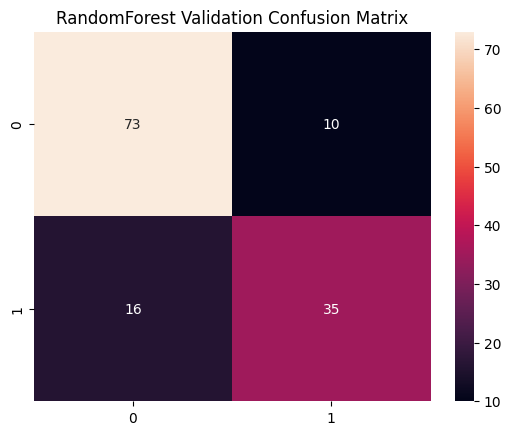

In [42]:
# Validation Report
y_hat = best_rf.predict(X_val)
print(f"RandomForest Validation Accuracy: {100*accuracy_score(y_val, y_hat):0.2f}%")
print("RandomForest Validation Classification Report:\n", classification_report(y_val, y_hat))
sns.heatmap(confusion_matrix(y_val, y_hat), annot=True, fmt='d')
plt.title('RandomForest Validation Confusion Matrix')
plt.show()